In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

In [20]:
class KineticMonteCarlo:
    def __init__(self, lattice_size, T, e_ads, e_des, e_diff, e_int_abs, e_int_des, time_array, time_factor):
        self.lattice_size = lattice_size
        self.lattice = np.zeros((lattice_size, lattice_size))
        self.T = T
        self.e_ads = e_ads
        self.e_des = e_des
        self.e_diff = e_diff
        self.e_int_abs = e_int_abs
        self.e_int_des = e_int_des
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time = time_array[0]
        self.time_array = time_array
        self.occupancy = {t: None for t in self.time_array}
        self.events_count = {"adsorption": 0, "desorption": 0, "diffusion": 0}
        self.adsorption = []
        self.desorption = []
        self.diffusion = []

    def pick_random_site(self):
        i, j = np.random.randint(0, self.lattice_size, size=2)
        return i, j

    def count_occupied_neighbors(self, site):
        neighbors = 0
        i, j = site
        for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            if 0 <= ni < self.lattice_size and 0 <= nj < self.lattice_size:
                neighbors += self.lattice[ni, nj]
        return neighbors

    def activation_energies(self, site):
        n_ij = self.count_occupied_neighbors(site)
        des = self.e_int_des * n_ij + self.e_des
        return des

    def calculate_transition_rates(self, site):
        E_des = self.activation_energies(site)
        k_ads = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-self.e_ads / (self.k_b * self.T))
        k_des = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))
        k_diff = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-self.e_diff / (self.k_b * self.T))
        k_total = k_ads + k_des + k_diff
        return k_ads, k_des, k_diff, k_total

    def select_event(self, k_ads, k_des, k_diff):
        total_propensity = k_ads + k_des + k_diff
        r = np.random.rand() * total_propensity
        if r < k_ads:
            return "adsorption"
        elif r < k_ads + k_des:
            return "desorption"
        else:
            return "diffusion"

    def run_simulation(self):
        end_time = self.time_array[-1]
        total_time = end_time - self.time_array[0]
        last_percentage = 0
        i=0

        while self.time < end_time:
            for t in self.time_array:
                if self.occupancy[t] is None and self.time >= t:
                    self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100


            site = self.pick_random_site()
            k_ads, k_des, k_diff, k_total = self.calculate_transition_rates(site)

            if k_total == 0:
                break  # No more events possible

            delta_t = (-np.log(np.random.rand()) / k_total)/self.factor
            self.time += delta_t

            event_type = self.select_event(k_ads, k_des, k_diff)

            if event_type == "adsorption":
                self.lattice[site] = 1
                self.events_count["adsorption"] += 1
            elif event_type == "desorption" and self.lattice[site] == 1:
                self.lattice[site] = 0
                self.events_count["desorption"] += 1
            elif event_type == "diffusion":
                self.events_count["diffusion"] += 1
                if self.lattice[site] == 1:
                    neighbors = [
                        (site[0] + dx, site[1] + dy)
                        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                        if 0 <= site[0] + dx < self.lattice_size and 0 <= site[1] + dy < self.lattice_size
                    ]
                    vacant_neighbors = [s for s in neighbors if self.lattice[s] == 0]
                    if vacant_neighbors:
                        new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
                        self.lattice[site], self.lattice[new_site] = 0, 1

            self.adsorption.append(self.events_count["adsorption"])
            self.desorption.append(self.events_count["desorption"])
            self.diffusion.append(self.events_count["diffusion"])

        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100

        return self.occupancy

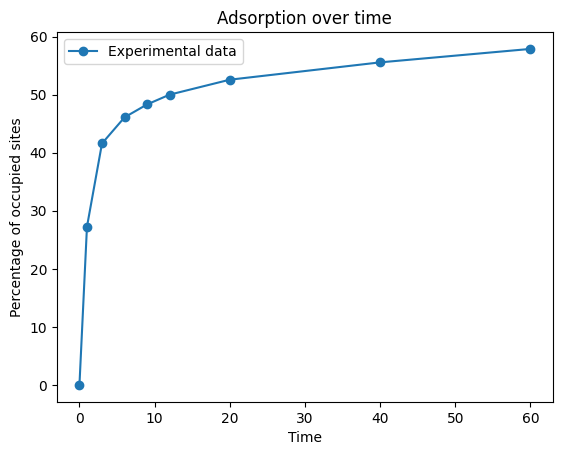

In [21]:
data = pd.read_csv('Datos recogidos.csv')
t = np.array([1,3,6,9,12,20,40,60])

for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.iloc[3] = data.iloc[3] * 10
data.reset_index(drop=True, inplace=True)
data.insert(0, 'T0', 0)


time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

plt.plot(time_array, data.iloc[5], marker='o', label='Experimental data')
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.legend()
plt.show()

{'adsorption': 37883, 'desorption': 16555, 'diffusion': 1688}
Saturation:  50.121191135734065 %


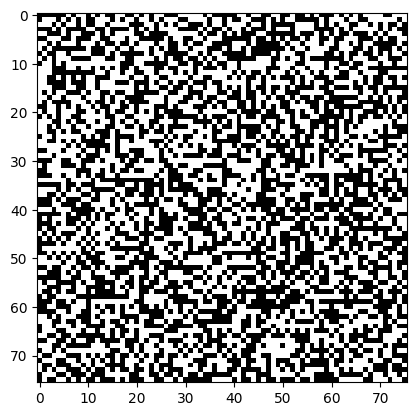

In [22]:
lattice_size = 76
T = 300
e_ads = 0.22
e_des = 0.24
e_diff = 0.3
e_int_abs = 0.12
e_int_des = -0.01
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
time_factor = 1e-7

KMC = KineticMonteCarlo(lattice_size=lattice_size, T=T, e_ads=e_ads, e_des=e_des, e_diff=e_diff, e_int_abs=e_int_abs, e_int_des=e_int_des,time_array=time_array, time_factor=time_factor)
occupancy = KMC.run_simulation()
print(KMC.events_count)
print("Saturation: ",np.sum(KMC.lattice)/(lattice_size**2)*100, "%")
plt.imshow(KMC.lattice, cmap='binary')
plt.show()


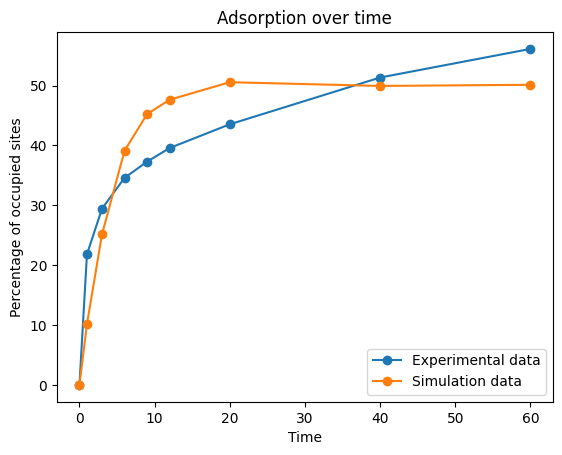

Mean Squared Error (MSE): 43.34320363900152


In [23]:
exp_data = data.iloc[8]
simulated_data = np.array(list(occupancy.values()))
simulated_data[0] = 0


plt.plot(time_array,exp_data,marker='o', label='Experimental data')
plt.plot(time_array,np.array(simulated_data), marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

mse = np.mean((np.array(exp_data) - np.array(simulated_data)) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

In [24]:
base_params = {
    "T": 300,  
    "e_ads": -1.82,  
    "e_des": 1.25,  
    "e_diff": -0.579,  
    "e_int_abs": 0.608,  
    "e_int_des": 0.89
}
variability = 0.05

In [25]:
low_e_ads = min(base_params["e_ads"] * (1 - variability), base_params["e_ads"] * (1 + variability))
high_e_ads = max(base_params["e_ads"] * (1 - variability), base_params["e_ads"] * (1 + variability))

low_e_des = min(base_params["e_des"] * (1 - variability), base_params["e_des"] * (1 + variability))
high_e_des = max(base_params["e_des"] * (1 - variability), base_params["e_des"] * (1 + variability))

low_e_diff = min(base_params["e_diff"] * (1 - variability), base_params["e_diff"] * (1 + variability))
high_e_diff = max(base_params["e_diff"] * (1 - variability), base_params["e_diff"] * (1 + variability))

low_e_int_abs = min(base_params["e_int_abs"] * (1 - variability), base_params["e_int_abs"] * (1 + variability))
high_e_int_abs = max(base_params["e_int_abs"] * (1 - variability), base_params["e_int_abs"] * (1 + variability))

low_e_int_des = min(base_params["e_int_des"] * (1 - variability), base_params["e_int_des"] * (1 + variability))
high_e_int_des = max(base_params["e_int_des"] * (1 - variability), base_params["e_int_des"] * (1 + variability))

In [ ]:
import numpy as np
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
from tqdm import tqdm

# Definir número de iteraciones
N_CALLS = 200

# Inicializar barra de progreso
progress_bar = tqdm(total=N_CALLS, desc="Optimización Bayesiana en Progreso", position=0)

# Variables para almacenar el mejor resultado
best_params = None
best_error = float("inf")

def loss_function(params):
    global start_time, best_params, best_error
    
    # Desempaquetar parámetros
    e_ads, e_des, e_diff, e_int_abs, e_int_des, lattice_size, T = params  

    # Ejecutar el modelo KMC
    kmc_model = KineticMonteCarlo(
        lattice_size=lattice_size, T=T, e_ads=e_ads, e_des=e_des, 
        e_diff=e_diff, e_int_abs=e_int_abs, e_int_des=e_int_des,
        time_array=np.array([0, 1, 3, 6, 9, 12, 20, 40, 60]), time_factor=1e-7
    )
    kmc_model.run_simulation()

    # Calcular error
    simulated_data = np.array(list(kmc_model.occupancy.values()))
    error = np.mean((simulated_data - exp_data) ** 2)

    # Actualizar mejores parámetros si se encuentra un menor error
    if error < best_error:
        best_error = error
        best_params = params
        print(f"🟢 Nuevo mejor error: {best_error:.6f} con parámetros {best_params}")

    # Calcular tiempos estimados
    elapsed_time = time.time() - start_time
    avg_time_per_iter = elapsed_time / (progress_bar.n + 1)
    estimated_time_left = avg_time_per_iter * (N_CALLS - progress_bar.n - 1)

    # Agregar información en la barra de progreso
    progress_bar.set_postfix({
        "Tiempo transcurrido": f"{elapsed_time:.2f} s",
        "Tiempo restante": f"{estimated_time_left:.2f} s",
        "Mejor error": f"{best_error:.6f}"
    })
    
    progress_bar.update(1)

    return error

# Definir espacio de búsqueda
space = [
    Real(low_e_ads, high_e_ads, name="e_ads"),
    Real(low_e_des, high_e_des, name="e_des"),
    Real(low_e_diff, high_e_diff, name="e_diff"),
    Real(low_e_int_abs, high_e_int_abs, name="e_int_abs"),
    Real(low_e_int_des, high_e_int_des, name="e_int_des"),
    Integer(60, 100, name="lattice_size"),
    Real(280,350, name="T"),
]

# Iniciar optimización
start_time = time.time()
result = gp_minimize(loss_function, space, n_calls=N_CALLS, random_state=42)
progress_bar.close()

# Finalizar optimización
end_time = time.time()
print("\n✅ Optimización completada")
print("🔹 Parámetros óptimos encontrados:", best_params)
print("🔹 Error mínimo encontrado:", best_error)
print(f"⏳ Tiempo total de ejecución: {end_time - start_time:.2f} segundos")


Optimización Bayesiana en Progreso:   0%|          | 0/200 [10:42:26<?, ?it/s]


{'adsorption': 5687, 'desorption': 323, 'diffusion': 799}
Saturation:  53.666666666666664 %


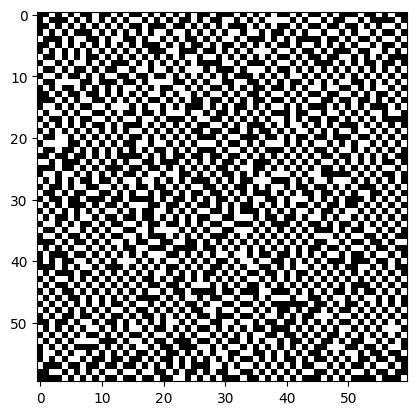

In [25]:
e_ads, e_des, e_diff, e_int_abs, e_int_des,lattice_size,T = best_params

kmc_model = KineticMonteCarlo(
    lattice_size= lattice_size, T=T, e_ads=e_ads, e_des=e_des, 
    e_diff=e_diff, e_int_abs=e_int_abs, e_int_des=e_int_des,
    time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
)
occupancy = kmc_model.run_simulation()
print(kmc_model.events_count)
print("Saturation: ",np.sum(kmc_model.lattice)/(lattice_size**2)*100, "%")
plt.imshow(kmc_model.lattice, cmap='binary')
plt.show()

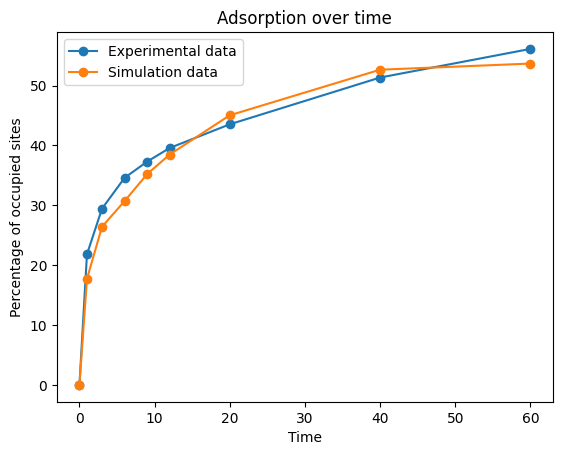

Mean Squared Error (MSE): 6.298440776704456


In [26]:
simulated_data = np.array(list(occupancy.values()))
simulated_data[0] = 0


plt.plot(time_array,exp_data,marker='o', label='Experimental data')
plt.plot(time_array,np.array(simulated_data), marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

mse = np.mean((np.array(exp_data) - np.array(simulated_data)) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

{'adsorption': 6094, 'desorption': 343, 'diffusion': 805}
Saturation:  53.75 %


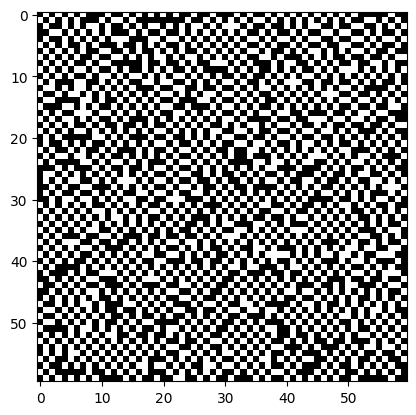

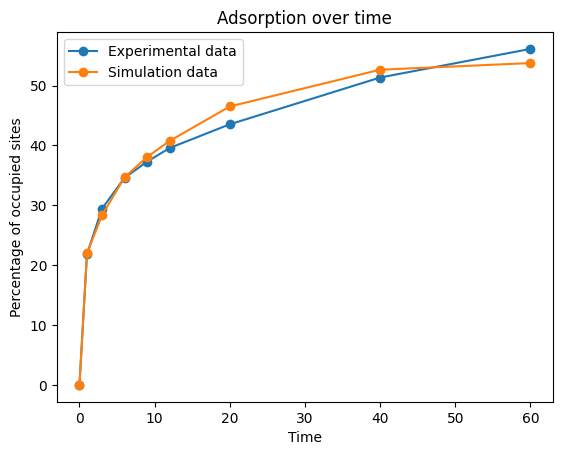

Mean Squared Error (MSE): 2.1539188015809905


In [31]:
while mse >= 3:
    e_ads, e_des, e_diff, e_int_abs, e_int_des,lattice_size,T = best_params

    kmc_model = KineticMonteCarlo(
        lattice_size= lattice_size, T=T, e_ads=e_ads, e_des=e_des, 
        e_diff=e_diff, e_int_abs=e_int_abs, e_int_des=e_int_des,
        time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
    )
    occupancy = kmc_model.run_simulation()

    simulated_data = np.array(list(occupancy.values()))
    simulated_data[0] = 0
    mse = np.mean((np.array(exp_data) - np.array(simulated_data)) ** 2)


print(kmc_model.events_count)
print("Saturation: ",np.sum(kmc_model.lattice)/(lattice_size**2)*100, "%")
plt.imshow(kmc_model.lattice, cmap='binary')
plt.show()

plt.plot(time_array,exp_data,marker='o', label='Experimental data')
plt.plot(time_array,np.array(simulated_data), marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

mse = np.mean((np.array(exp_data) - np.array(simulated_data)) ** 2)
print(f"Mean Squared Error (MSE): {mse}")